In [1]:
# General Dependencies
import timeit, os
import numpy as np
import scipy.io as io

# Preprocessing Dependencies
from trefide.utils import psd_noise_estimate

# PMD Model Dependencies
from trefide.pmd import batch_decompose, batch_recompose, overlapping_batch_decompose, overlapping_batch_recompose

# Plot & Video Dependencies
import matplotlib.pyplot as plt
from trefide.plot import pixelwise_ranks
from trefide.extras.util_plot import comparison_plot, correlation_traces, snr_per_frame, nearest_frame_corr
from trefide.video import write_mpl, play_cv2

# Set Data Information
dataset = "Q-State Bio"
filename = os.path.join("..", "data", "prepared_sampleMovie.npy")

from trefide.decimation import decimated_decompose, decimated_batch_decompose, downsample_video, downsample_image, downsample_signal, overlapping_dbd

%load_ext autoreload
%autoreload 2

# Load Data & Set Params

In [2]:
mov = np.load(filename)
fov_height, fov_width, num_frames = mov.shape

In [3]:
max_components = 50
maxiter=50
consec_failures = 3
tol = 5e-3
block_height = 40
block_width = 40
spatial_cutoff = (block_height*block_width / ((block_height*(block_width-1) + block_width*(block_height-1))))
lambda_tv = .0025
overlapping = False

# Compress & Denoise

In [4]:
def downsample_movie(fov_height, fov_width, d_sub, num_frames, t_sub, mov):
    Y_ds = np.asarray([downsample_image(fov_height, fov_width, d_sub, np.asfortranarray(frame)) 
                       for frame in mov.transpose(2,0,1)])
    Y_ds = np.asarray([downsample_signal(num_frames, t_sub, np.ascontiguousarray(signal))
                       for signal in np.reshape(Y_ds.transpose(1,2,0),
                                                (int(fov_height*fov_width/(d_sub**2)), num_frames))])
    return np.reshape(Y_ds, (int(fov_height/d_sub), int(fov_width/d_sub), int(num_frames/t_sub)))

## Decimated

In [5]:
#mov_ds = downsample_video(fov_height, fov_width, 2, num_frames, 2, np.asfortranarray(mov))
mov_ds = downsample_movie(fov_height, fov_width, 2, num_frames, 2, np.asfortranarray(mov))
mov_ds = np.ascontiguousarray(mov_ds)

In [6]:
max_iters_ds = 40
max_iters = 10
d_sub=2
t_sub=2

In [7]:
if not overlapping:
    # Perform Blockwise PMD In Parallel
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices = decimated_batch_decompose(fov_height, fov_width, d_sub, 
                                              num_frames, t_sub,
                                              mov, mov_ds, 
                                              block_height, block_width,
                                              lambda_tv,
                                              max_components,
                                              consec_failures,
                                              max_iters, max_iters_ds, tol)

    # Use Compressed Components To Reconstruct Denoise Video
    mov_denoised = np.asarray(batch_recompose(spatial_components,
                                              temporal_components,
                                              block_ranks,
                                              block_indices))
else:
    # Perform 4x Overlapping Blockwise PMD In Parallel
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices,\
    block_weights = overlapping_dbd(fov_height, fov_width, d_sub, 
                                    num_frames, t_sub,
                                    mov, mov_ds, 
                                    block_height, block_width,
                                    lambda_tv,
                                    max_components,
                                    consec_failures,
                                    max_iters, max_iters_ds, tol)
    mov_denoised = np.asarray(overlapping_batch_recompose(fov_height, fov_width, num_frames,
                                                          block_height, block_width,
                                                          spatial_components,
                                                          temporal_components,
                                                          block_ranks,
                                                          block_indices,
                                                          block_weights)) 

In [8]:
import timeit
def time_dec_pmd():
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices = decimated_batch_decompose(fov_height, fov_width, 2, num_frames, 2,
                                              mov, mov_ds, block_height, block_width,
                                              lambda_tv,
                                              max_components,
                                              consec_failures,
                                              max_iters, max_iters_ds, tol)

timeit.timeit(time_dec_pmd, number=5)/5

7.646633862999442

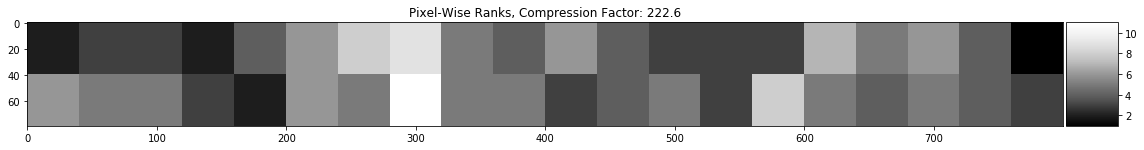

In [9]:
if overlapping:
    pixelwise_ranks(block_ranks['no_skew']['full'], fov_height, fov_width, num_frames, block_height, block_width)
else:
    pixelwise_ranks(block_ranks, fov_height, fov_width, num_frames, block_height, block_width)

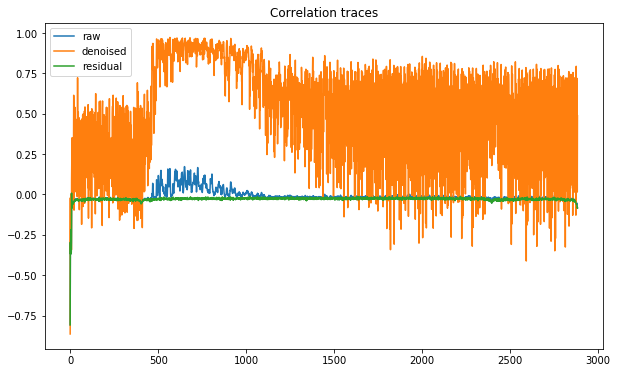

In [10]:
correlation_traces(mov, mov_denoised, mov - mov_denoised)
plt.show()

Local correlation:  range [-2.8e-02 5.2e-01]
Local correlation:  range [-1.0e+00 1.0e+00]
Local correlation:  range [-6.4e-02 6.6e-02]


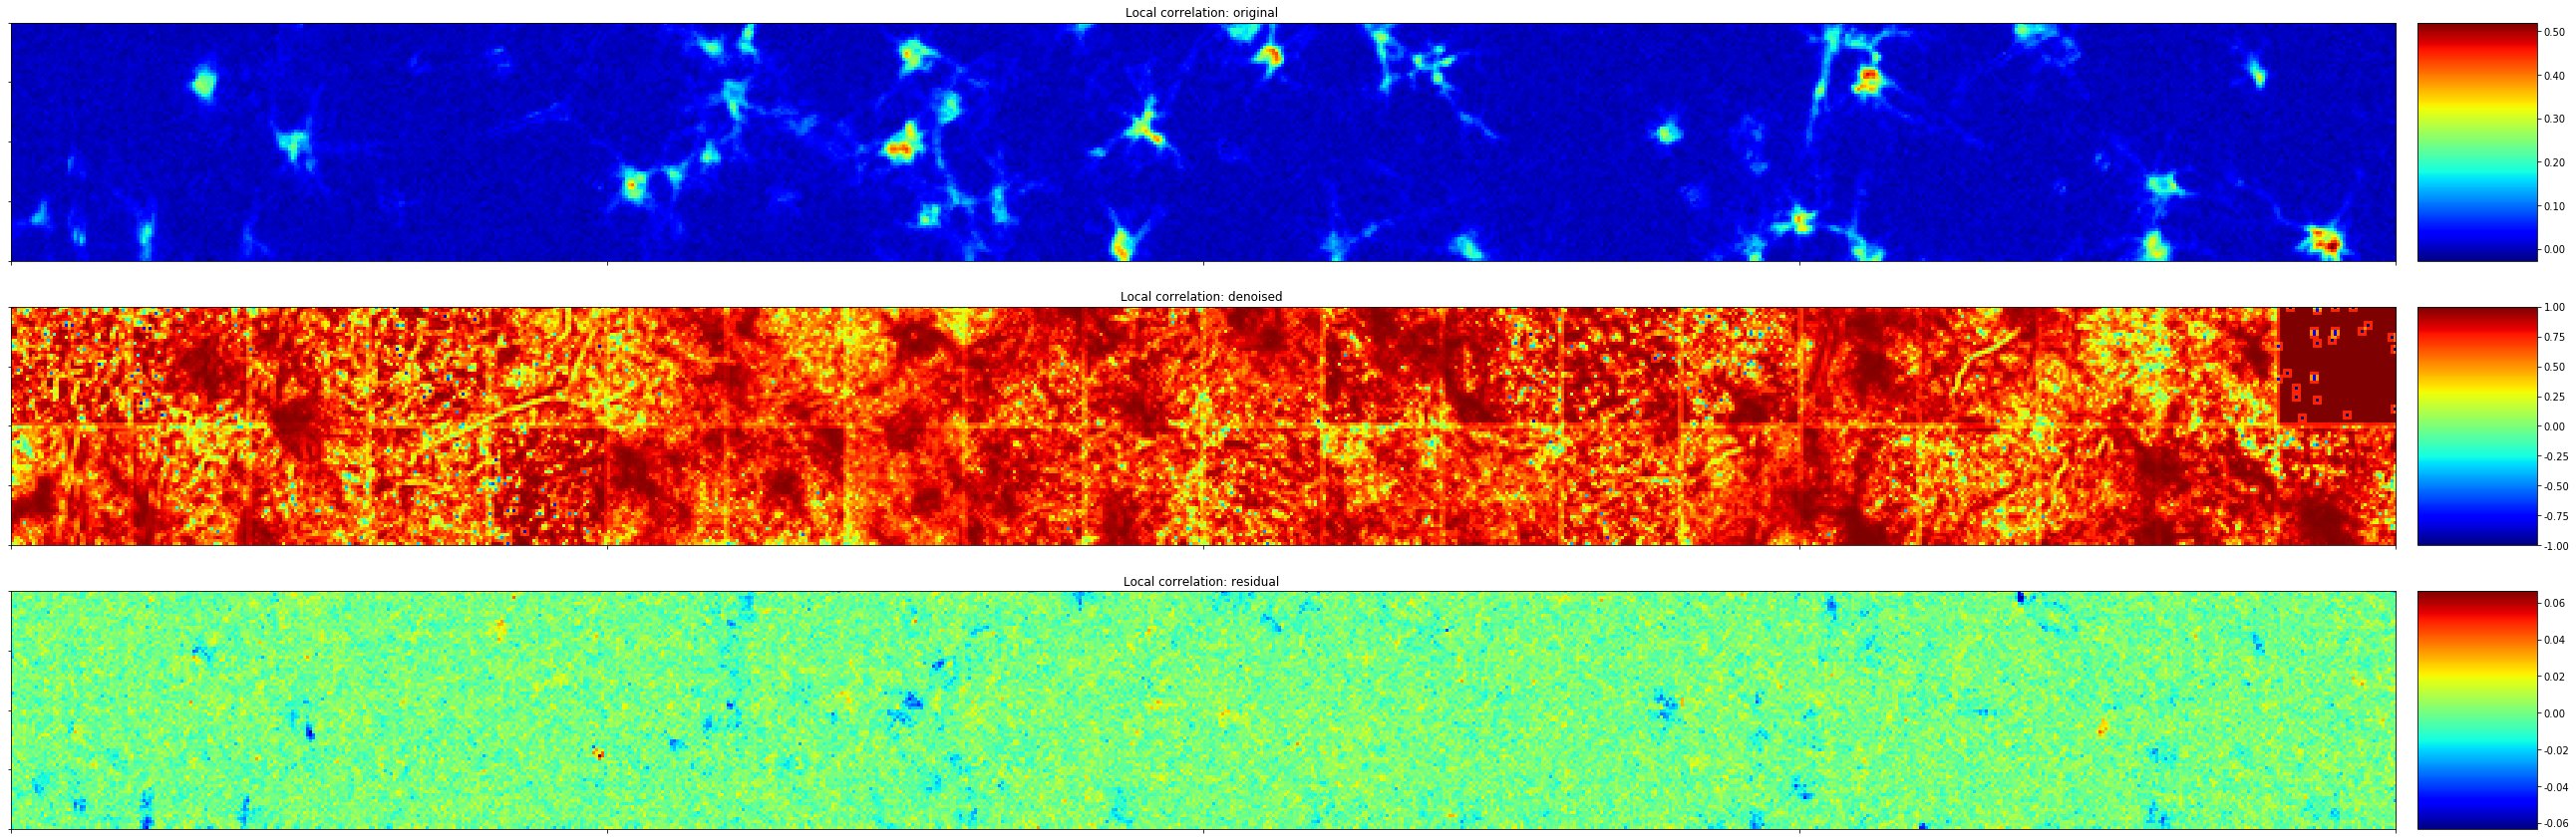

In [11]:
comparison_plot([mov, mov_denoised], plot_orientation="horizontal")

In [12]:
play_cv2(np.vstack([mov, mov_denoised, mov - mov_denoised]), magnification=2.5)

## Original

In [13]:
if not overlapping:
    # Perform Blockwise PMD In Parallel
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices = batch_decompose(fov_height, fov_width, num_frames,
                                    mov, block_height, block_width,
                                    lambda_tv, spatial_cutoff,
                                    max_components,
                                    consec_failures,
                                    maxiter, tol)

    # Use Compressed Components To Reconstruct Denoise Video
    mov_denoised = np.asarray(batch_recompose(spatial_components,
                                              temporal_components,
                                              block_ranks,
                                              block_indices))
else:
    # Perform 4x Overlapping Blockwise PMD In Parallel
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices,\
    block_weights = overlapping_batch_decompose(fov_height, fov_width, num_frames,
                                                mov, block_height, block_width,
                                                lambda_tv, spatial_cutoff,
                                                max_components,
                                                consec_failures,
                                                maxiter, tol)
    mov_denoised = np.asarray(overlapping_batch_recompose(fov_height, fov_width, num_frames,
                                                          block_height, block_width,
                                                          spatial_components,
                                                          temporal_components,
                                                          block_ranks,
                                                          block_indices,
                                                          block_weights)) 

In [14]:
import timeit
def time_pmd():
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices = batch_decompose(fov_height, fov_width, num_frames,
                                    mov, block_height, block_width,
                                    lambda_tv, spatial_cutoff,
                                    max_components,
                                    consec_failures,
                                    maxiter, tol)

timeit.timeit(time_pmd, number=5)/5

10.067304553199211

# Produce Diagnostics

### Pixel-Wise Ranks

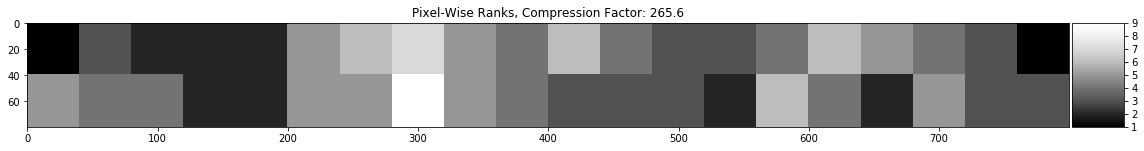

In [15]:
if overlapping:
    pixelwise_ranks(block_ranks['no_skew']['full'], fov_height, fov_width, num_frames, block_height, block_width)
else:
    pixelwise_ranks(block_ranks, fov_height, fov_width, num_frames, block_height, block_width)

### Correlation Traces

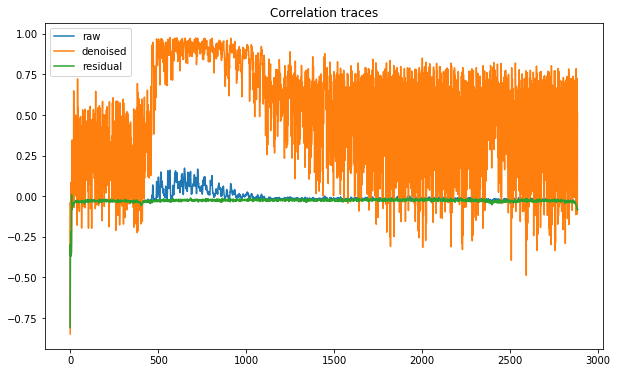

In [16]:
correlation_traces(mov, mov_denoised, mov - mov_denoised)
plt.show()

### Correlation Images

Local correlation:  range [-2.8e-02 5.2e-01]
Local correlation:  range [-1.0e+00 1.0e+00]
Local correlation:  range [-6.3e-02 9.7e-02]


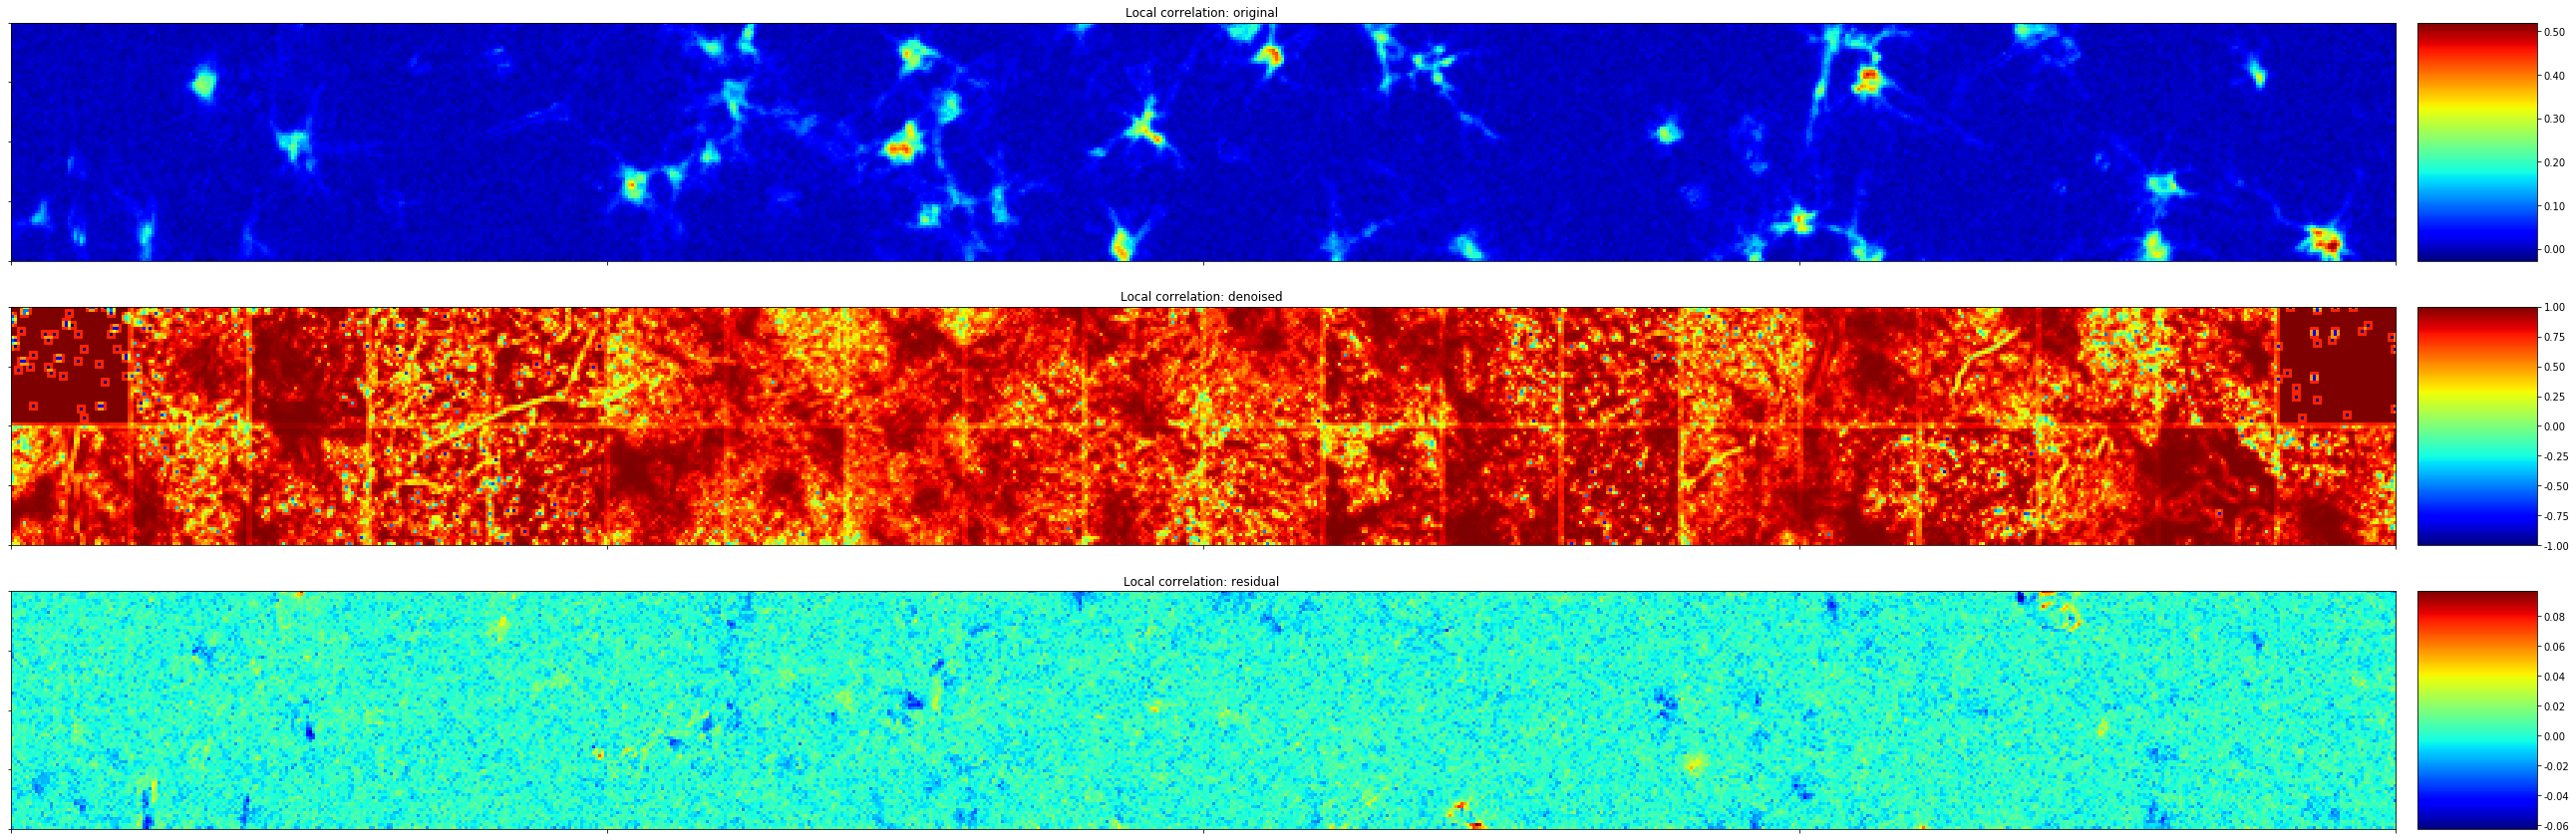

In [17]:
comparison_plot([mov, mov_denoised], plot_orientation="horizontal")

## Videos

### Render With OpenCV3

In [ ]:
play_cv2(np.vstack([mov, mov_denoised, mov - mov_denoised]), magnification=2.5)

### Write With MPL Formatting

In [ ]:
write_mpl(mov_list=[mov, mov_denoised, mov - mov_denoised], filename=dataset, fr=60, horizontal=False)